<a href="https://colab.research.google.com/github/shreyab1111/MultiLexNorm-Challenge/blob/main/Danish/da_ln_seq2seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Importing libraries
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [7]:
# Both train and test set are in the root data directory
train_path = '/content/drive/MyDrive/NLP/Lexical Normalisation/Multilexnorm Challenge/Danish/da.train.norm.txt'
test_path = '/content/drive/MyDrive/NLP/Lexical Normalisation/Multilexnorm Challenge/Danish/da.train.norm.txt'

In [8]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 20000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 #512

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

ATTENTION_FUNC='general'


In [9]:
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial
# in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", ":", "#","@")
    w = re.sub(r"[^a-zA-Z?.!,¿:#@]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

In [10]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_path, sep="\t", header=None, names=[INPUT_COLUMN,TARGET_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : str(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : str(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ str(x)).tolist()

print(input_data[:5])
print(target_data[:5])
print(target_input_data[:5])

['jeg', 'er', 'træt', 'af', 'GoT']
['jeg <eos>', 'er <eos>', 'træt <eos>', 'af <eos>', 'GoT <eos>']
['<sos> jeg', '<sos> er', '<sos> træt', '<sos> af', '<sos> GoT']


In [11]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()


65

In [12]:
# Create a tokenizer for the input texts and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[1000])
print(input_sequences[1000])

Max Input Length:  1
Subtle
[1016]


In [13]:
# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[1000])
print(target_sequences[1000])
print(target_input_data[1000])
print(target_sequences_inputs[1000])

Max Target Length:  4
Subtle <eos>
[1005, 1]
<sos> Subtle
[2, 1005]


In [14]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 3167 unique input tokens.
Found 3125 unique output tokens.


In [15]:
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (9392, 1)
encoder_inputs[0]: [8]
decoder_inputs[0]: [ 2 10  0  0]
decoder_inputs.shape: (9392, 4)


In [16]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets))
dataset = dataset.shuffle(len(input_data)).batch(
    BATCH_SIZE, drop_remainder=True)


In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [18]:
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError(
                'Attention score must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(rnn_size)
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)

    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True) # (batch_size, 1, max_len)
        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True) #(batch_size, 1, max_len)
        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1]) #shape (batch size, max len,hidden_dim)

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1))) # (batch_size, max len, 1)

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)

        # alignment a_t = softmax(score)
        alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
        
        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output) # (batch_size, 1, hidden_dim)

        return context, alignment


In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, attention_func):
        super(Decoder, self).__init__()
        self.attention = LuongAttention(hidden_dim, attention_func)
        self.hidden_dim = hidden_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(input_sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, hidden_dim)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, hidden_dim)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, hidden_dim),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.wc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [20]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM, ATTENTION_FUNC)

# Call the encoder and then the decoder
initial_state = encoder.init_states(1)
encoder_outputs = encoder(tf.constant([[1]]), initial_state)
decoder_outputs = decoder(tf.constant(
    [[1]]), encoder_outputs[1:], encoder_outputs[0])

In [21]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [22]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    loss = 0.
    acc = 0.
    logits = None
    
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)
            # Store the logits to calculate the accuracy
            logit = K.expand_dims(logit, axis=1)
            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits,logit), axis=1)
        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits)
    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1], acc

In [23]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [24]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)


Epoch 1 Batch 0 Loss 4.0238 Acc:0.0000
Epoch 1 Batch 100 Loss 1.2213 Acc:0.5859
Time taken for 1 epoch 16.3662 sec

Epoch 2 Batch 0 Loss 1.2382 Acc:0.6434
Epoch 2 Batch 100 Loss 0.8172 Acc:0.7656
Time taken for 1 epoch 8.6871 sec

Epoch 3 Batch 0 Loss 0.7753 Acc:0.7674
Epoch 3 Batch 100 Loss 0.7515 Acc:0.7969
Time taken for 1 epoch 7.9521 sec

Epoch 4 Batch 0 Loss 0.4716 Acc:0.8594
Epoch 4 Batch 100 Loss 0.5293 Acc:0.8438
Time taken for 1 epoch 8.3628 sec

Epoch 5 Batch 0 Loss 0.2777 Acc:0.9062
Epoch 5 Batch 100 Loss 0.4411 Acc:0.8359
Time taken for 1 epoch 7.9246 sec

Epoch 6 Batch 0 Loss 0.2870 Acc:0.8906
Epoch 6 Batch 100 Loss 0.3627 Acc:0.8450
Time taken for 1 epoch 8.3337 sec

Epoch 7 Batch 0 Loss 0.0878 Acc:0.9766
Epoch 7 Batch 100 Loss 0.1584 Acc:0.9062
Time taken for 1 epoch 7.9428 sec

Epoch 8 Batch 0 Loss 0.0628 Acc:0.9766
Epoch 8 Batch 100 Loss 0.0825 Acc:0.9531
Time taken for 1 epoch 8.3315 sec

Epoch 9 Batch 0 Loss 0.0119 Acc:1.0000
Epoch 9 Batch 100 Loss 0.0464 Acc:0.9766

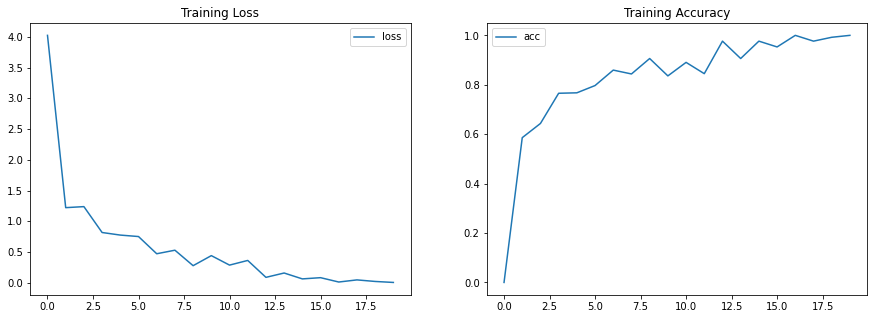

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [26]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [38]:
def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    print(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    alignments = []

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break
    # Join the output words
    print(' '.join(out_words))
    return np.array(alignments), input_text.split(' '), out_words

In [40]:
n_predictions=50
test_sents = input_data[0:(0+n_predictions)]
for i, test_sent in enumerate(test_sents):
  alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, 
                                                     word2idx_outputs, idx2word_outputs)

jeg
jeg <eos>
er
er <eos>
træt
træt <eos>
af
af <eos>
GoT
got <eos>
,
, <eos>
jeg
jeg <eos>
synes
synes <eos>
ikke
ikke <eos>
Tyrion
tyrion <eos>
er
er <eos>
sjov
sjov <eos>
længere
længere <eos>
,
, <eos>
jeg
jeg <eos>
synes
synes <eos>
Daenaerys
daenaerys <eos>
er
er <eos>
meget
meget <eos>
mindre
mindre <eos>
klog
klog <eos>
og
og <eos>
sej
sej <eos>
end
end <eos>
hun
hun <eos>
plejede
plejede <eos>
at
at <eos>
være
være <eos>
,
, <eos>
og
og <eos>
jeg
jeg <eos>
kan
kan <eos>
ikke
ikke <eos>
komme
komme <eos>
mig
mig <eos>
over
over <eos>
at
at <eos>
The
the <eos>
White
white <eos>
Walkers
walkers <eos>
bare
bare <eos>
var
var <eos>
en
en <eos>
plotdevice
plotdevice <eos>
for
for <eos>
at
at <eos>
sætte
sætte <eos>
hende
hende <eos>
ligeligt
ligeligt <eos>
op
op <eos>
